In [ ]:
# train

df = pd.read_csv("../data/processed/electricity_total_consumption_15min.csv",
                 parse_dates=['datetime'], index_col='datetime')

# train/test split
horizon = 96 * 14  # 14 days of 15-min intervals
train = df.iloc[:-horizon]
test  = df.iloc[-horizon:]

print(f"Train: {train.shape}, Test: {test.shape}")


def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true,y_pred)
    mape = np.mean(abs((y_true - y_pred)/y_true) * 100)
    return {"RMSE" : rmse, "MAE" : mae, "MAPE" : mape}


print(f" The Average value is {df['total_consumption_kWh'].mean()}")


Train: (156284, 1), Test: (1344, 1)
 The Average value is 1802067.0432098564


17:44:24 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:44 - cmdstanpy - INFO - Chain [1] done processing


Baseline Prophet: {'RMSE': np.float64(159720.36639261694), 'MAE': 129331.4524695467, 'MAPE': np.float64(7.422718347696065)}
Tuned Prophet:    {'RMSE': np.float64(168799.92181576535), 'MAE': 134286.66217844625, 'MAPE': np.float64(7.2855113554951565)}


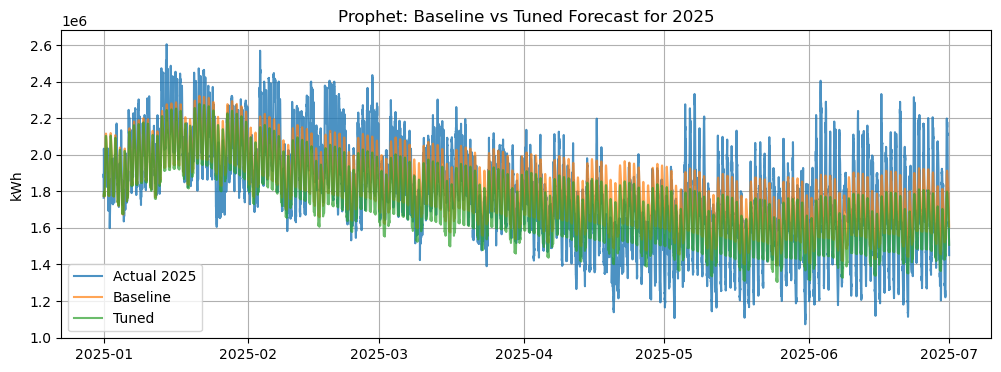

In [27]:
# —————————————
# Prophet.
# —————————————

# —————————————
# Data split by date (train: ≤2024-12-31, test: 2025-01-01 onward)
# —————————————
train = df.loc[: "2024-12-31 23:45"]
test  = df.loc["2025-01-01":]
horizon = len(test)

# —————————————
# Prepare for Prophet
# —————————————
prophet_df = train.reset_index().rename(columns={
    "datetime": "ds",
    "total_consumption_kWh": "y"
})

# —————————————
# Baseline Model.
# —————————————
m1 = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m1.fit(prophet_df)

# —————————————
# Forecast (Baseline).
# —————————————
future1  = m1.make_future_dataframe(periods=horizon, freq='15min')
forecast1 = m1.predict(future1)
y_pred1  = forecast1.set_index('ds')['yhat'][-horizon:]
metrics1 = evaluate(test['total_consumption_kWh'], y_pred1)

# —————————————
# Tuned Model.
# —————————————
m2 = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m2.fit(prophet_df)

# —————————————
# Forecast (Tuned).
# —————————————
future2  = m2.make_future_dataframe(periods=horizon, freq='15min')
forecast2 = m2.predict(future2)
y_pred2  = forecast2.set_index('ds')['yhat'][-horizon:]
metrics2 = evaluate(test['total_consumption_kWh'], y_pred2)

# —————————————
# Print & compare
# —————————————
print("Baseline Prophet:", metrics1)
print("Tuned Prophet:   ", metrics2)

plt.figure(figsize=(12,4))
plt.plot(test.index,       test['total_consumption_kWh'], label='Actual 2025', alpha=0.8)
plt.plot(test.index,       y_pred1,                        label='Baseline',    alpha=0.7)
plt.plot(test.index,       y_pred2,                        label='Tuned',       alpha=0.7)
plt.legend()
plt.title("Prophet: Baseline vs Tuned Forecast for 2025")
plt.ylabel("kWh")
plt.grid(True)
plt.show()


/var/folders/vj/8wn3h6116s1g_mdd5ktxzjt00000gn/T/ipykernel_88208/331057041.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hr = df.resample('1H').sum().dropna()


SARIMAX (hourly) metrics: {'RMSE': np.float64(443560.93423812225), 'MAE': 339861.4915737466, 'MAPE': np.float64(5.293790837522821)}


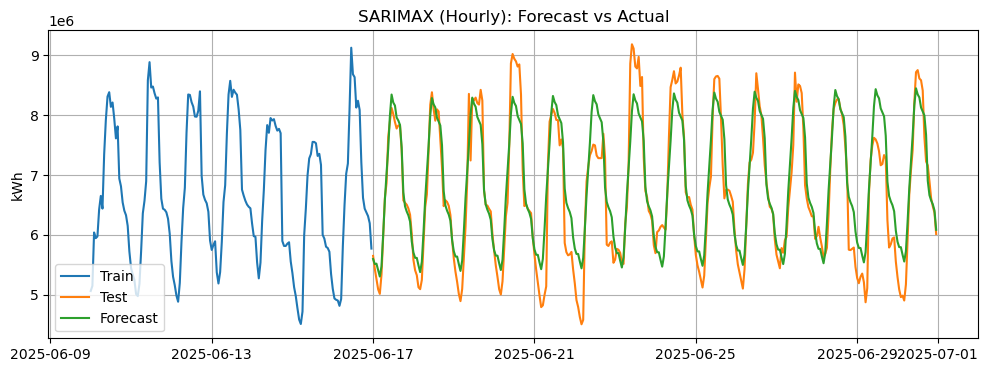

In [29]:
import pandas as pd
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Load 15-min total‐consumption series
df = pd.read_csv(
    "../data/processed/electricity_total_consumption_15min.csv",
    parse_dates=['datetime'], index_col='datetime'
)

# 2. Resample to hourly totals (sum, not mean)
df_hr = df.resample('1H').sum().dropna()

# 3. Train/Test split (last 14 days)
horizon_hr = 24 * 14
train_hr = df_hr.iloc[:-horizon_hr]
test_hr  = df_hr.iloc[-horizon_hr:]

# 4. Fit SARIMAX on hourly data (s=24)
model_hr = SARIMAX(
    train_hr['total_consumption_kWh'],
    order=(1,1,1),
    seasonal_order=(1,1,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False, maxiter=50)

# 5. Forecast
pred_hr = model_hr.get_forecast(steps=horizon_hr).predicted_mean

# 6. Safe evaluation
def evaluate(y_true, y_pred):
    mask = y_true > 0
    y_t, y_p = y_true[mask], y_pred[mask]
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    mae  = mean_absolute_error(y_t, y_p)
    mape = (np.abs((y_t - y_p) / y_t).mean()) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

metrics_hr = evaluate(test_hr['total_consumption_kWh'], pred_hr)
print("SARIMAX (hourly) metrics:", metrics_hr)

# 7. Plot
plt.figure(figsize=(12,4))
plt.plot(train_hr.index[-168:], train_hr['total_consumption_kWh'].iloc[-168:], label='Train')
plt.plot(test_hr.index,           test_hr['total_consumption_kWh'],             label='Test')
plt.plot(test_hr.index,           pred_hr,                                      label='Forecast')
plt.legend()
plt.title("SARIMAX (Hourly): Forecast vs Actual")
plt.ylabel("kWh")
plt.grid(True)
plt.show()


Train shape: (140255, 14) Test shape: (17373, 14)
XGBoost on 2025 data → RMSE: 104685.74, MAE: 80322.03, MAPE: 4.64%


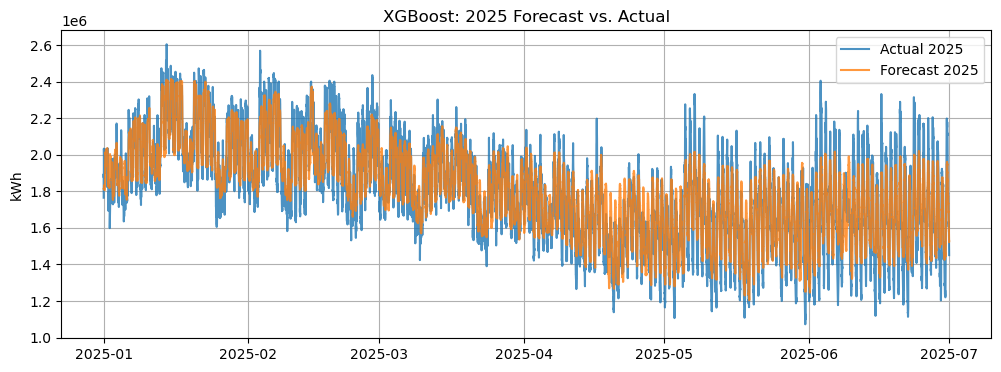

In [39]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

feat_path = Path("../data/processed/electricity_features_15min.csv")
df = pd.read_csv(feat_path, parse_dates=['datetime'], index_col='datetime')

# —————————————
# Data split by date (train: ≤2024-12-31, test: 2025-01-01 onward)
# —————————————
train = df.loc[: "2024-12-31 23:45"]   # all data up to end of 2024
test  = df.loc["2025-01-01":]           # all 2025 data

X_train = train.drop(columns=['total_consumption_kWh'])
y_train = train['total_consumption_kWh']
X_test  = test.drop(columns=['total_consumption_kWh'])
y_test  = test['total_consumption_kWh']

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


# —————————————
# Train XGBoost
# —————————————
xgb = XGBRegressor(
    n_estimators=1000, learning_rate=0.01,
    max_depth=6, subsample=0.8, colsample_bytree=0.8,
    random_state=69, verbosity=1
)
xgb.fit(X_train, y_train)

# —————————————
# Forecast & Evaluation.
# —————————————

y_pred = xgb.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100

print(f"XGBoost on 2025 data → RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")


# —————————————
# Plot.
# —————————————

plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test,  label='Actual 2025', alpha=0.8)
plt.plot(y_test.index, y_pred,  label='Forecast 2025', alpha=0.8)
plt.title("XGBoost: 2025 Forecast vs. Actual")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/10


/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1971/1971 - 36s - 18ms/step - loss: 0.0042 - val_loss: 6.9697e-04
Epoch 2/10
1971/1971 - 35s - 18ms/step - loss: 0.0012 - val_loss: 4.9305e-04
Epoch 3/10
1971/1971 - 35s - 18ms/step - loss: 7.7821e-04 - val_loss: 3.8084e-04
Epoch 4/10
1971/1971 - 34s - 17ms/step - loss: 6.5427e-04 - val_loss: 3.7627e-04
Epoch 5/10
1971/1971 - 35s - 18ms/step - loss: 6.1361e-04 - val_loss: 3.4986e-04
Epoch 6/10
1971/1971 - 34s - 17ms/step - loss: 5.9646e-04 - val_loss: 3.4938e-04
Epoch 7/10
1971/1971 - 35s - 18ms/step - loss: 5.8676e-04 - val_loss: 3.5801e-04
Epoch 8/10
1971/1971 - 35s - 18ms/step - loss: 5.7921e-04 - val_loss: 3.4259e-04
Epoch 9/10
1971/1971 - 35s - 18ms/step - loss: 5.7021e-04 - val_loss: 3.4598e-04
Epoch 10/10
1971/1971 - 34s - 17ms/step - loss: 5.5994e-04 - val_loss: 3.5897e-04
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
LSTM → RMSE: 31049.82, MAE: 21404.35, MAPE: 1.21%


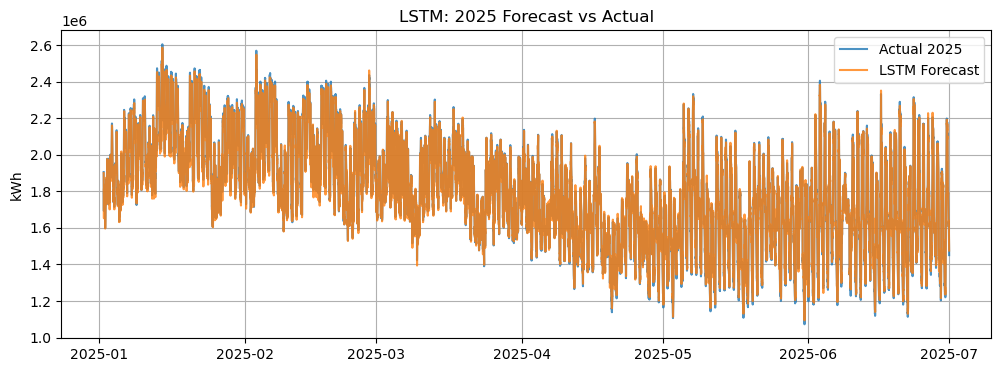

In [31]:
# —————————————
# 4c. LSTM (Deep Learning)
# —————————————

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error


# —————————————
# Load feature matrix and split by date (train: ≤2024-12-31, test: 2025-01-01 onward)
# —————————————

feat_path = Path("../data/processed/electricity_features_15min.csv")
df = pd.read_csv(feat_path, parse_dates=['datetime'], index_col='datetime')
train = df.loc[: "2024-12-31 23:45"]
test  = df.loc["2025-01-01":]

# —————————————
# Scale target Variable
# —————————————

scaler = MinMaxScaler()
train_vals = scaler.fit_transform(train[['total_consumption_kWh']])
test_vals  = scaler.transform(test [['total_consumption_kWh']])

# —————————————
# Create Sequence of LSTM
# —————————————

def create_sequences(data, seq_len=96):
    X,y = [],[]
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i,0])
        y.append(data[i,0])
    return np.array(X), np.array(y)

seq_len=96

X_train, y_train = create_sequences(train_vals, seq_len)
X_test, y_test = create_sequences(test_vals,seq_len )


# —————————————
#Reshape
# —————————————


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# —————————————
# Build LSTM
# —————————————


model = Sequential([
    LSTM(64, input_shape=(seq_len, 1 ), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# —————————————
# Train Model
# —————————————

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=2
)

# —————————————
# Forcasting
# —————————————

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).ravel()
y_true = test['total_consumption_kWh'].iloc[seq_len:].values


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

print(f"LSTM → RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")



test_idx = test.index[seq_len:]
plt.figure(figsize=(12,4))
plt.plot(test_idx, y_true, label='Actual 2025', alpha=0.8)
plt.plot(test_idx, y_pred, label='LSTM Forecast', alpha=0.8)
plt.title("LSTM: 2025 Forecast vs Actual")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.show()

